imports

In [1]:
import os
import pickle
import timit_to_ipa
import sim_phonemes
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import seaborn as sns
import numpy as np

functions to load the saved file which contains mapping from phoneme to codebook entry

In [2]:
def load_ph_code_entry_map(
    path_phn_file: str#path of file
):  # loading phoneme to codeentry mapping for the file
    with open(path_phn_file, "rb") as f:
        phn_dict = pickle.load(f)
    return phn_dict


def load_ph_code_entry_map_folder(
    pickle_path#path of folder
):  # loading phoneme to codeentry mapping for the whole folder
    phn_dict = {}
    for subdir, dirs, files in os.walk(pickle_path):
        for file in files:
            if "_phn.pkl" in file:
                phn_dict_f = load_ph_code_entry_map(
                    subdir + "/" + file
                )  # loading phoneme to codeentry mapping for the file
                for p, val in phn_dict_f.items():
                    if p in phn_dict:
                        phn_dict[p] += phn_dict_f[p]
                    else:
                        phn_dict[p] = phn_dict_f[p]
    return phn_dict


function to plot compression

In [3]:
def plot_compress(sim_mt, phn_to_dist_1_keys,type_of_compression = "TSNE", kmeans = False):
    if type_of_compression == "mds":
        compress = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1).fit_transform(
            sim_mt
        )
    elif type_of_compression == "TSNE":
        # compress = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3,random_state = 0).fit_transform(sim_mt)
        compress = TSNE(n_components=2,verbose=1, perplexity=9, n_iter=1000, learning_rate=200,random_state = 0).fit_transform(sim_mt)
    elif type_of_compression == "PCA":
        compress = PCA(n_components=2,random_state = 0).fit_transform(sim_mt)  
        # val1 = compress[:,0]
        # val2 = compress[:,1]
        # compress[:,1] = np.array(val1)*-1
        # compress[:,0] = np.array(val2)*-1
    if kmeans == True:
        kmns = KMeans(n_clusters=12, random_state=0).fit(compress)
        colors_cluster = kmns.labels_
        sns.scatterplot(compress[:, 0], compress[:, 1],c = colors_cluster)
    else:
        sns.scatterplot(compress[:, 0], compress[:, 1])
    for i, phn in enumerate(phn_to_dist_1_keys):
        v = random.uniform(0, 0.5)
        plt.annotate(phn, (compress[:, 0][i], compress[:, 1][i]))
    plt.xlabel("{type_of_compression} axis 1")
    plt.ylabel("{type_of_compression} axis 2")
    plt.savefig("compress.pdf", bbox_inches="tight")

providing path folder which contains the phoneme to code entry mapping

In [4]:
codebook = 1
folder_name = "timit_pkl_xlsr"
path_folder = (
    f"/Users/mohammedmaqsoodshaik/Desktop/hiwi/task1/{folder_name}/codebook{codebook}/"
)
phn_dict1 = load_ph_code_entry_map_folder(path_folder)
codebook = 2
folder_name = "timit_pkl_xlsr"
path_folder = (
    f"/Users/mohammedmaqsoodshaik/Desktop/hiwi/task1/{folder_name}/codebook{codebook}/"
)
phn_dict2 = load_ph_code_entry_map_folder(path_folder)
for key_1,val_1 in phn_dict1.items():
        phn_dict1[key_1] +=  list(np.asarray(phn_dict2[key_1]) + 320)
phn_dict=phn_dict1

calculating similarity with sorted phonemes and creating timit to ipa mappings

In [5]:
abs_discount = 0.00000000002 #absolute discounting hyperparameter
sim_mt,sorted_phonemes = sim_phonemes.similarity_calculation(phn_dict, phn_dict,abs_discount)#passing obtained dictionary with phonemes to codeentries mapping
labels = [timit_to_ipa.timit_2_ipa[k] for k in sorted_phonemes]#timit to ipa conversion

number of codebook entries utilized out of 640:155


plotting similarity matrix, dendogram and compression

/Users/mohammedmaqsoodshaik/miniforge3/envs/wav2vec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 61 samples in 0.000s...
[t-SNE] Computed neighbors for 61 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 61 / 61
[t-SNE] Mean sigma: 0.497341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.430679
[t-SNE] KL divergence after 1000 iterations: 0.179582


/Users/mohammedmaqsoodshaik/miniforge3/envs/wav2vec/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


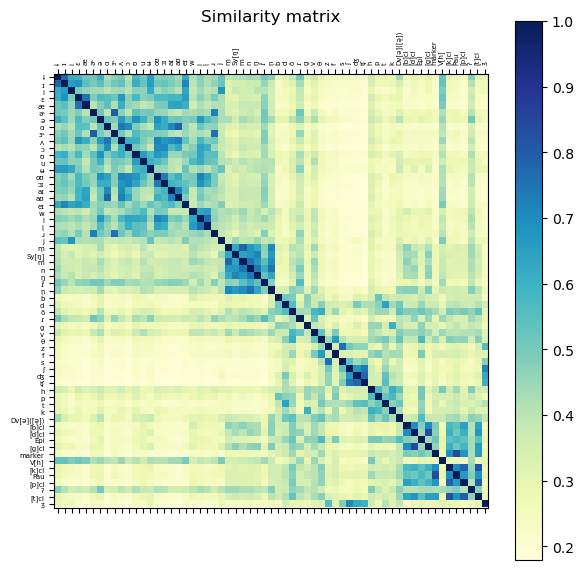

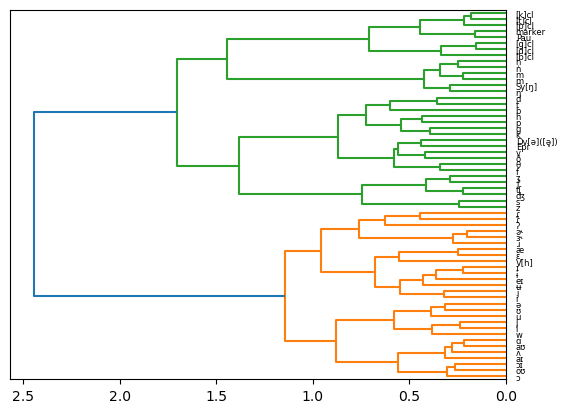

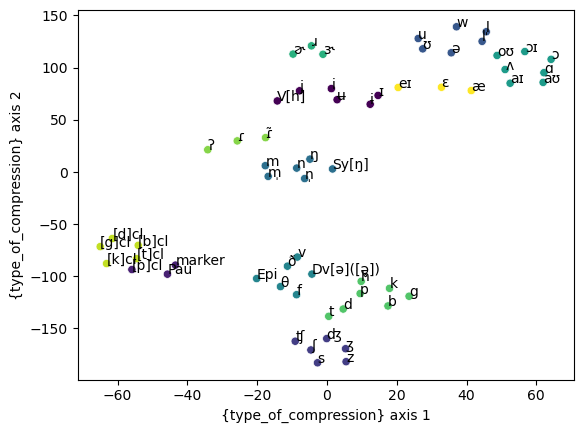

In [6]:
sim_phonemes.plot_sim(sim_mt, labels, labels)
plt.figure()
plot_compress(sim_mt, labels,"TSNE",True)
plt.show()